### Diffusion Model inference

In [35]:
import warnings
warnings.filterwarnings('ignore')

import jax
import functools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from tqdm import tqdm
from read_data import get_cond_ecmwf_dataset, get_mean_std_data
from swirl_dynamics.lib import diffusion as dfn_lib
from swirl_dynamics.lib import solvers as solver_lib
from swirl_dynamics.projects import probabilistic_diffusion as dfn
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [2]:
ecmwf = xr.open_mfdataset('data/test/*.zarr').ecmwf.load()
chirps = xr.open_mfdataset('data/test/*.zarr').chirps.load()

In [36]:
cond_workdir = "/home/u/amine.barkaoui/chkpts/cond_diffusion_ecmwf_wetseas_100_2016_24"

DATA_STD = 0.31

num_samples_per_cond = 1

In [37]:
diffusion_scheme = dfn_lib.Diffusion.create_variance_exploding(
    sigma=dfn_lib.tangent_noise_schedule(),
    data_std=DATA_STD,
)

In [38]:
cond_denoiser_model = dfn_lib.PreconditionedDenoiser(
    out_channels=1,
    num_channels=(64, 128),
    downsample_ratio=(2, 2),
    num_blocks=4,
    noise_embed_dim=128,
    padding="SAME",
    use_attention=True,
    use_position_encoding=True,
    num_heads=8,
    sigma_data=DATA_STD,
    cond_resize_method="cubic",
    cond_embed_dim=128,
)

In [39]:
trained_state = dfn.DenoisingModelTrainState.restore_from_orbax_ckpt(
    f"{cond_workdir}/checkpoints", step=None
)
# Construct the inference function
cond_denoise_fn = dfn.DenoisingTrainer.inference_fn_from_state_dict(
    trained_state, use_ema=True, denoiser=cond_denoiser_model
)

cond_sampler = dfn_lib.SdeSampler(
    input_shape=(28, 28, 1),
    integrator=solver_lib.EulerMaruyama(),
    tspan=dfn_lib.edm_noise_decay(
        diffusion_scheme, rho=7, num_steps=256, end_sigma=1e-3,
    ),
    scheme=diffusion_scheme,
    denoise_fn=cond_denoise_fn,
    guidance_transforms=(),
    apply_denoise_at_end=True,
    return_full_paths=False,
)

In [40]:
generate = jax.jit(
    functools.partial(cond_sampler.generate, num_samples_per_cond)
)

In [41]:
batch_size = ecmwf.time.size

In [42]:
%%time

test_ds = iter(get_cond_ecmwf_dataset(split="test", batch_size=batch_size))

batch_test = next(test_ds)

test_batch_cond = batch_test["cond"]

cond_samples = jax.vmap(generate, in_axes=(0, 0, None))(
    jax.random.split(jax.random.PRNGKey(8888), batch_size),
    test_batch_cond,
    None,  # Guidance inputs = None since no guidance transforms involved
)

np.save(f"data/diffusion/batch_{num_samples_per_cond}samples", cond_samples)

CPU times: user 36min, sys: 41.6 s, total: 36min 41s
Wall time: 11min 9s


#### Visualization

In [14]:
mean_chirps, var_chirps, mean_ecmwf, var_ecmwf = get_mean_std_data(split="train")

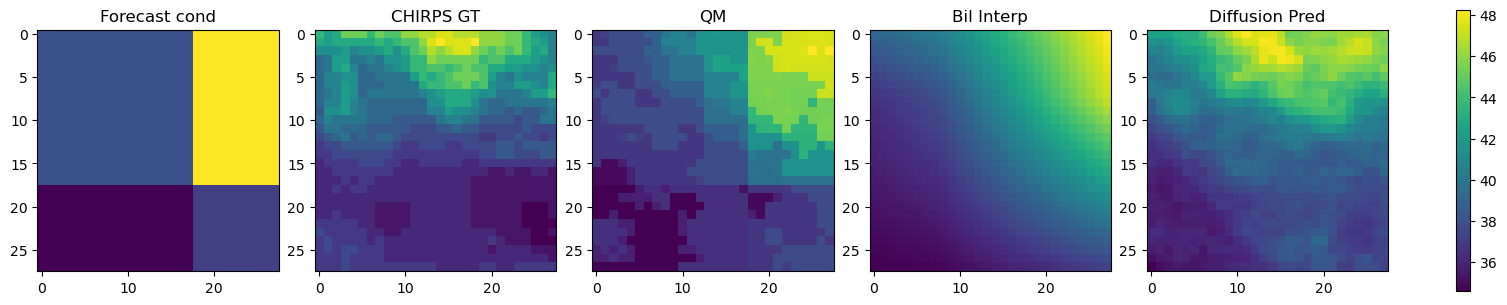

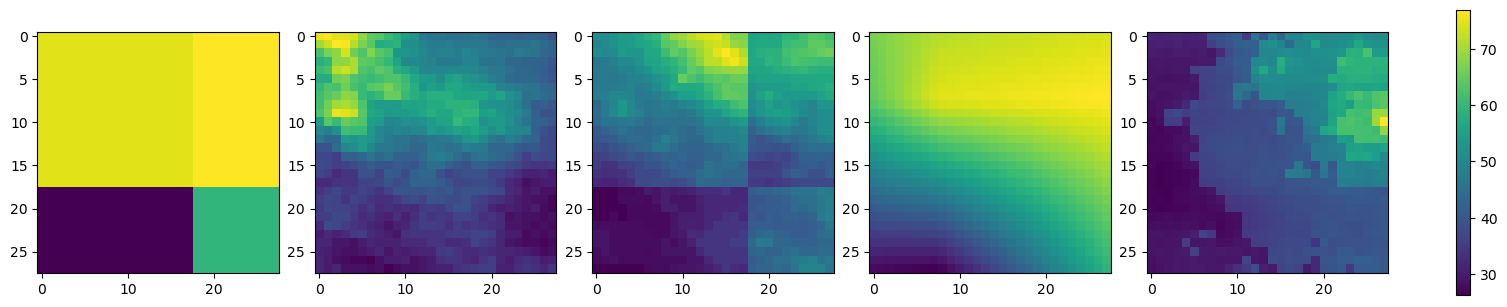

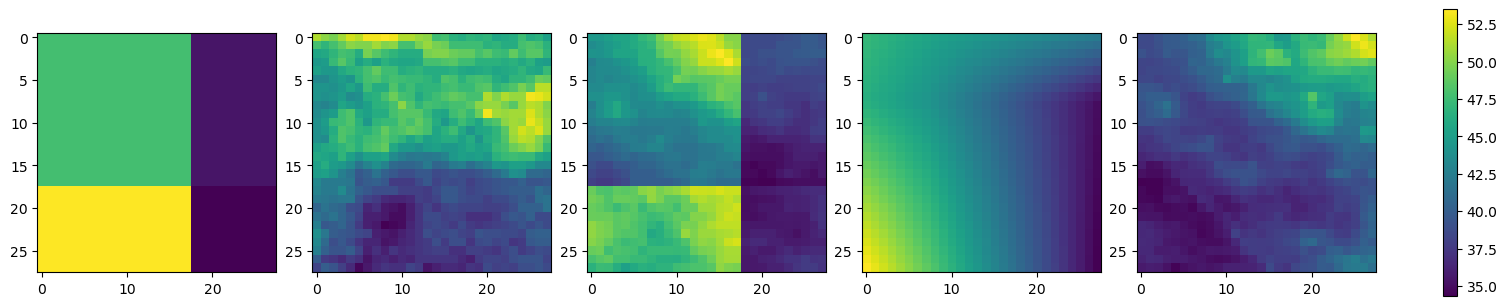

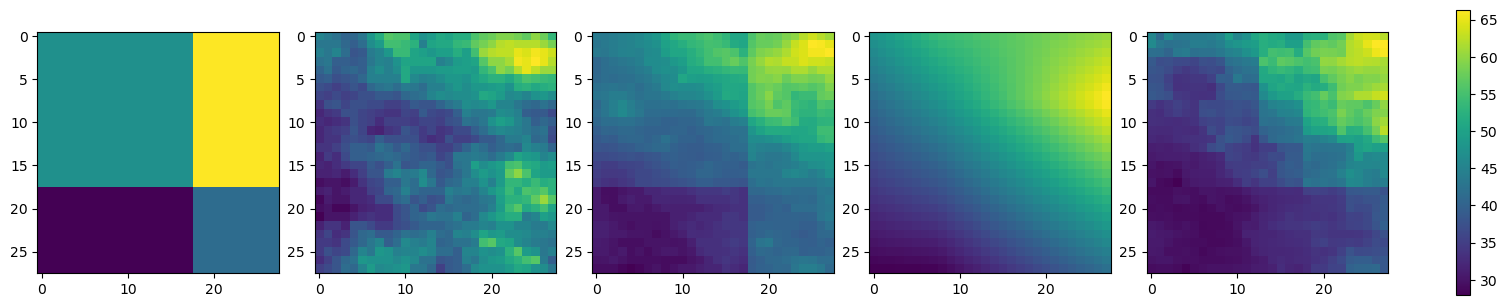

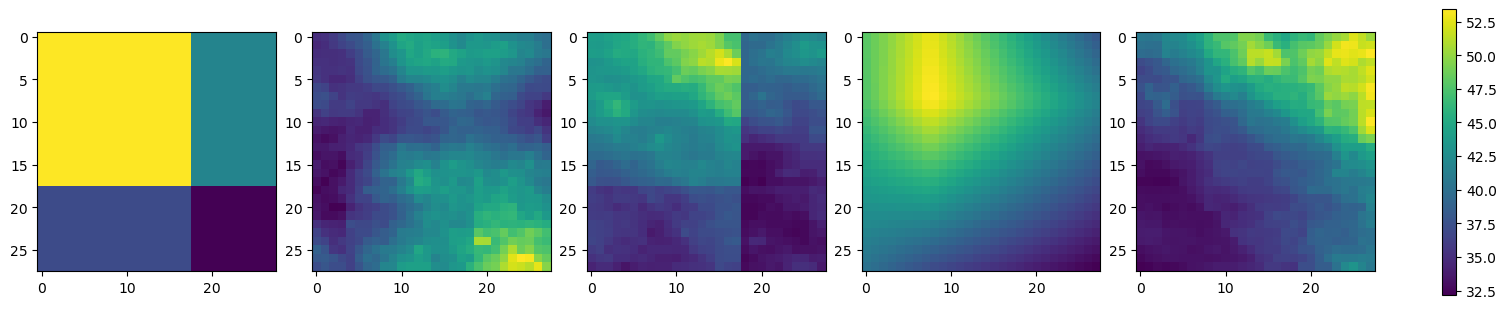

In [45]:
# Benchmarks
qm = xr.open_zarr("data/benchmarks_results/QM/test_quantile_mapping.zarr").scen
bilint = xr.open_zarr("data/benchmarks_results/bilinear/test_bilinear.zarr").bilint

batch_test = next(iter(get_cond_ecmwf_dataset(split="test", batch_size=batch_size)))

test_batch_cond = batch_test["cond"]['channel:low_res']
test_batch_gt = batch_test["x"]

start = 15
end = 20

xx = np.load(f"data/diffusion/batch_5samples.npy")
xx = xx * (var_chirps + 1e-4) + mean_chirps

test_batch_cond = test_batch_cond * (var_ecmwf + 1e-4) + mean_ecmwf
test_batch_gt = test_batch_gt * (var_chirps + 1e-4) + mean_chirps

for b in range(start, end):
    fig, ax = plt.subplots(1, 5, constrained_layout=True, figsize=(15, 3))
      
    mini = None #np.min(test_batch_gt[b,:,:,0])
    maxi = None #np.max(test_batch_gt[b,:,:,0])

    ax[0].imshow(test_batch_cond[b,:,:,0])
    #ax[1].imshow(ecmwf.isel(time=b).values)
    ax[1].imshow(test_batch_gt[b,:,:,0], vmin=mini, vmax=maxi)
    ax[2].imshow(qm.isel(time=b).values, vmin=mini, vmax=maxi)
    ax[3].imshow(bilint.isel(time=b).values, vmin=mini, vmax=maxi)
    im = ax[4].imshow(np.mean(xx, axis=1)[b,:,:,0], vmin=mini, vmax=maxi)
    fig.colorbar(im, ax=ax)
    
    if b == start:
        ax[0].set_title("Forecast cond")
        ax[1].set_title("CHIRPS GT")
        ax[2].set_title("QM")
        ax[3].set_title("Bil Interp")
        ax[4].set_title("Diffusion Pred")
        
plt.show()

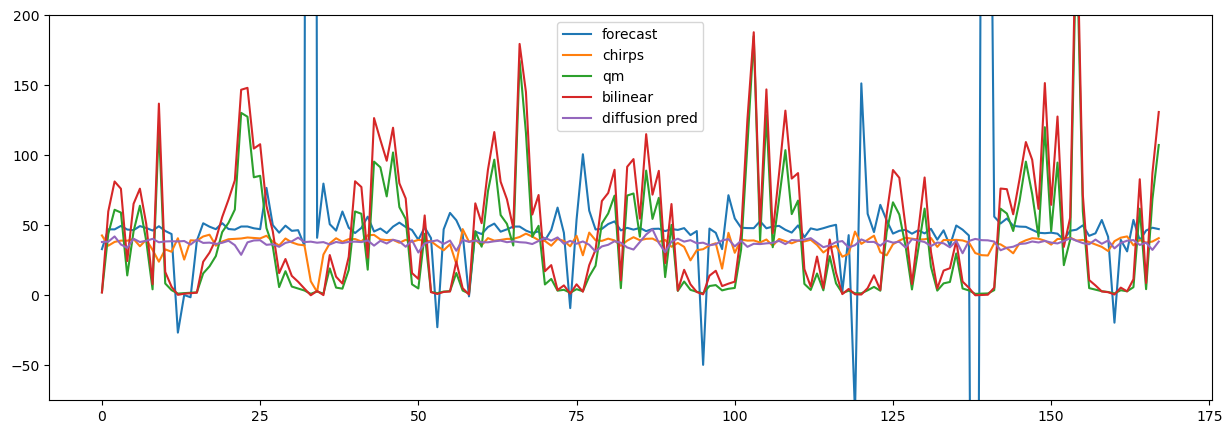

In [46]:
pix_lon_index = 10
pix_lat_index = 10

plt.figure(figsize=(15, 5))

plt.plot(test_batch_cond[:,pix_lat_index,pix_lon_index,0], label='forecast')
plt.plot(test_batch_gt[:,pix_lat_index,pix_lon_index,0], label='chirps')
plt.plot(qm.isel(longitude=pix_lon_index, latitude=pix_lat_index).values, label='qm')
plt.plot(bilint.isel(longitude=pix_lon_index, latitude=pix_lat_index).values, label='bilinear')
plt.plot(np.mean(xx, axis=1)[:,pix_lat_index,pix_lon_index,0], label='diffusion pred')

plt.ylim(-75, 200)
plt.legend()
        
plt.show()

##### **Inference on training dataset for SPI**

In [8]:
train_input = xr.open_mfdataset('data/train/*.zarr').ecmwf.load()

/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-pa

In [10]:
n_iter = 7
batch_size = train_input.time.size // n_iter

In [11]:
%%time

train_ds = iter(get_cond_ecmwf_dataset(split="train", batch_size=batch_size))

for batch in range(n_iter):

    batch_train = next(train_ds)

    train_batch_cond = batch_train["cond"]

    cond_samples = jax.vmap(generate, in_axes=(0, 0, None))(
        jax.random.split(jax.random.PRNGKey(8888), batch_size),
        train_batch_cond,
        None,  # Guidance inputs = None since no guidance transforms involved
    )

    np.save(f"data/diffusion/batch_train_{batch}.py", cond_samples)

2024-03-28 15:30:04.415795: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


CPU times: user 18min 30s, sys: 8min 54s, total: 27min 25s
Wall time: 27min 7s
